# Using OBIA for estimating area of Solar Panels in Spain

Using STAC, I am going to download imagery, segment the solar panels and estimate the area they occupy in the fields.

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import rasterio as rio
import xarray as xr
import rioxarray

import dask.array as da # handle dask arrays
from IPython.display import Image # visualize URLs
import pystac_client # connecting to the STAC API
from rasterio.enums import Resampling # perform re-sampling operations
import shapely # create vector objects
import stackstac # build an on-demand STAC data cube

from src.utils import stretch_histogram, normalize
from src.indices import ndvi_calc, ndbi_calc

In [4]:
api_url = 'https://earth-search.aws.element84.com/v1'
client = pystac_client.Client.open(api_url)
for collection in client.get_collections():
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


In [5]:
shapely.__version__

'1.8.5.post1'

In [6]:
collection = 'sentinel-2-l2a'

#coordinates 
lat = 37.364
lon = -6.923
point = shapely.geometry.Point(lon, lat)
date_range = '2025-04-01/2025-05-16'

In [7]:
search = client.search(
    collections = [collection],
    intersects=point,
    datetime=date_range,
    query = ['eo:cloud_cover<10']
)

items = search.item_collection()
len(items)

2

In [8]:
item_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs = 'EPSG:4326')
item_df 

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,proj:centroid,mgrs:utm_zone,mgrs:latitude_band,...,s2:datatake_type,s2:datastrip_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((-7.69213 37.94031, -7.87145 37.31390...",2025-05-15T15:21:11.337Z,sentinel-2b,sentinel-2,[msi],6.094903,32629,"{'lat': 37.42613, 'lon': -7.22372}",29,S,...,INS-NOBS,S2B_OPER_MSI_L2A_DS_2BPS_20250515T135717_S2025...,0.980395,2025-05-15T11:20:58.831000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/f069...,True,{'sentinel2-to-stac': '2025.03.06'},2025-05-15T15:21:11.337Z
1,"POLYGON ((-7.69554 37.94035, -7.87124 37.32824...",2025-04-22T19:32:50.586Z,sentinel-2a,sentinel-2,[msi],4.524603,32629,"{'lat': 37.42651, 'lon': -7.2248}",29,S,...,INS-NOBS,S2A_OPER_MSI_L2A_DS_2APS_20250422T180305_S2025...,0.992053,2025-04-22T11:21:12.566000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/0950...,True,{'sentinel2-to-stac': '2025.03.06'},2025-04-22T19:32:50.586Z


In [9]:
item_df['s2:nodata_pixel_percentage']

0    4.252186
1    4.083012
Name: s2:nodata_pixel_percentage, dtype: float64

In [10]:
item_df.explore()

In [11]:
ids = item_df.loc[
  (item_df['eo:cloud_cover'] <= 5) &
  (item_df['s2:nodata_pixel_percentage'] <= 4.1)
]

item = items[ids.index[0]]
item.datetime

datetime.datetime(2025, 4, 22, 11, 21, 12, 566000, tzinfo=tzutc())

In [12]:
aoi = gpd.read_file('solar_aoi.json')
bbox = aoi.total_bounds
aoi.explore()

In [13]:
thumbnail = item.assets["thumbnail"].href
Image(url = thumbnail)

In [14]:
assets = ["red","green","blue","nir", 'swir16', "scl"]
cube_all = stackstac.stack(
    item, 
    assets, 
    bounds_latlon = bbox, 
    epsg=32629
    )
scl = cube_all.sel(band=["scl"])
s2_mask = da.isin(scl, [3,8,9])
cube = cube_all.where(~s2_mask)
cube = cube.to_dataset(dim = 'band')

In [15]:
cube

<xarray.Dataset> Size: 4MB
Dimensions:                                  (time: 1, y: 273, x: 277, band: 6)
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 8B 2025-04...
    id                                       (time) <U24 96B 'S2A_29SPB_20250...
  * x                                        (x) float64 2kB 6.829e+05 ... 6....
  * y                                        (y) float64 2kB 4.138e+06 ... 4....
    s2:datastrip_id                          <U64 256B 'S2A_OPER_MSI_L2A_DS_2...
    s2:processing_baseline                   <U5 20B '05.11'
    ...                                       ...
    title                                    (band) <U30 720B 'Red - 10m' ......
    raster:bands                             (band) object 48B {'nodata': 0, ...
    common_name                              (band) object 48B 'red' ... None
    center_wavelength                        (band) object 48B 0.665 ... None
    full_width_half_max                      (band) object 48B 0.038 ... None
    epsg                                     int64 8B 32629
Dimensions without coordinates: band
Data variables:
    red                                      (time, y, x) float64 605kB dask.array<chunksize=(1, 273, 277), meta=np.ndarray>
    green                                    (time, y, x) float64 605kB dask.array<chunksize=(1, 273, 277), meta=np.ndarray>
    blue                                     (time, y, x) float64 605kB dask.array<chunksize=(1, 273, 277), meta=np.ndarray>
    nir                                      (time, y, x) float64 605kB dask.array<chunksize=(1, 273, 277), meta=np.ndarray>
    swir16                                   (time, y, x) float64 605kB dask.array<chunksize=(1, 273, 277), meta=np.ndarray>
    scl                                      (time, y, x) float64 605kB dask.array<chunksize=(1, 273, 277), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32629, bounds=(682890.0, 4135730.0, 685660.0...
    crs:         epsg:32629
    transform:   | 10.00, 0.00, 682890.00|\n| 0.00,-10.00, 4138460.00|\n| 0.0...
    resolution:  10.0

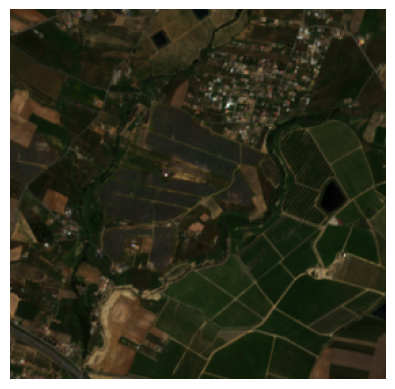

In [22]:
rgb = np.dstack((
    normalize(cube['red'][0,:,:]),
    normalize(cube['green'][0,:,:]),
    normalize(cube['blue'][0,:,:])
    )
)
plt.imshow(rgb)
plt.axis('off')
plt.show()

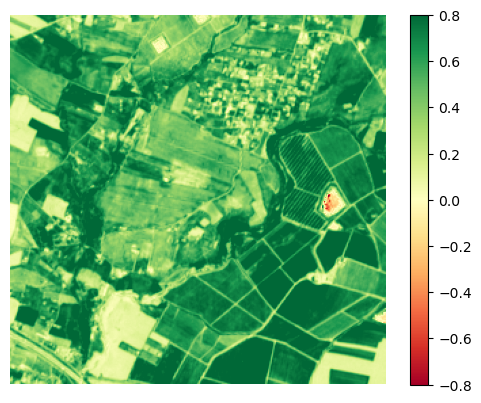

In [28]:
#calculate NDVI
ndvi = ndvi_calc(
    normalize(cube.red), 
    normalize(cube.nir)
    )

plt.imshow(ndvi[0,:, :], cmap = 'RdYlGn', vmin = -0.8, vmax = 0.8)
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
#Adding NDVI to the datacube
cube['ndvi'] = ndvi

<xarray.DataArray (time: 1, y: 273, x: 277)> Size: 605kB
dask.array<truediv, shape=(1, 273, 277), dtype=float64, chunksize=(1, 273, 277), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 8B 2025-04...
    id                                       (time) <U24 96B 'S2A_29SPB_20250...
  * x                                        (x) float64 2kB 6.829e+05 ... 6....
  * y                                        (y) float64 2kB 4.138e+06 ... 4....
    s2:datastrip_id                          <U64 256B 'S2A_OPER_MSI_L2A_DS_2...
    s2:processing_baseline                   <U5 20B '05.11'
    ...                                       ...
    view:azimuth                             float64 8B 103.8
    s2:generation_time                       <U27 108B '2025-04-22T18:03:05.0...
    earthsearch:s3_path                      <U79 316B 's3://sentinel-cogs/se...
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:tile_id                               <U62 248B 'S2A_OPER_MSI_L2A_TL_2...
    epsg                                     int64 8B 32629

In [48]:
agriculture = np.dstack((
    normalize(cube.swir16[0, ...]),
    normalize(cube.nir[0, ...]),
    normalize(cube.blue[0, ...])
))

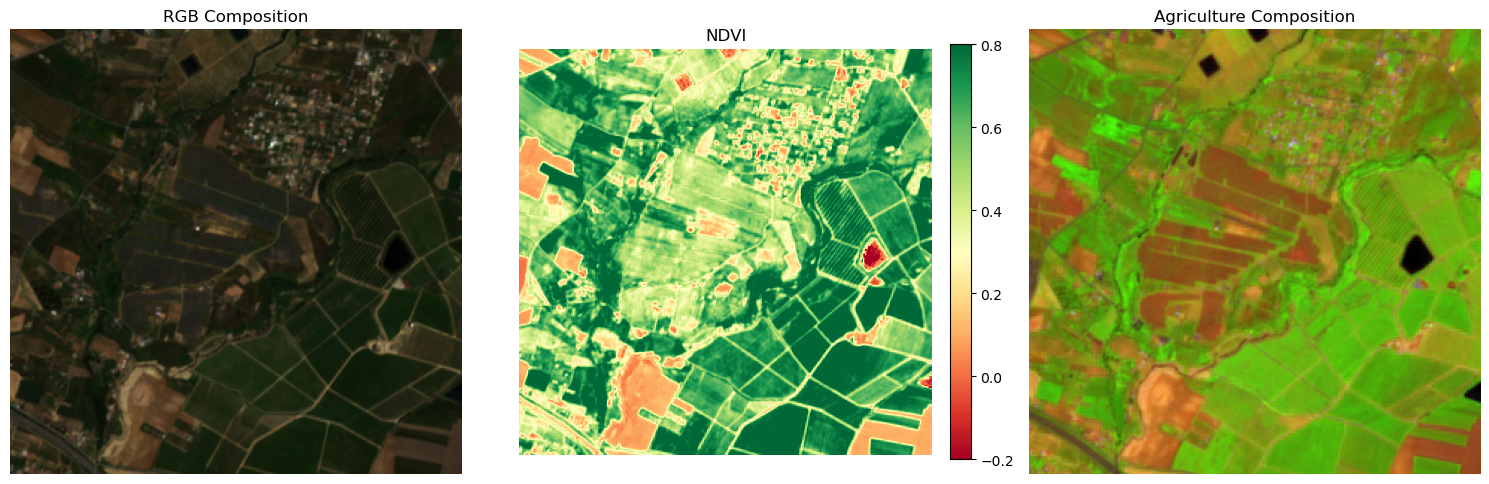

In [60]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,8))


ax[0].imshow(rgb)
ax[0].set_title('RGB Composition')

#NDVI Plot
im = ax[1].imshow(cube.ndvi[0,...], cmap ='RdYlGn', vmin = -0.2, vmax = 0.8)
ax[1].set_title('NDVI')
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

#Agriculture Plot
ax[2].imshow(agriculture)
ax[2].set_title('Agriculture Composition')

for axis in ax:
    axis.set_axis_off()

plt.tight_layout()
plt.savefig('solar_panels.png', dpi = 300)

plt.show()


# Image Segmentation